In [ ]:
# Para cargar lo necesario
import pickle
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import NLocal, CRZGate, RXGate
from qiskit.circuit import Parameter

# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
import customFunctions as cf

c:\Users\danie\anaconda3\envs\qiskit_tfm\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


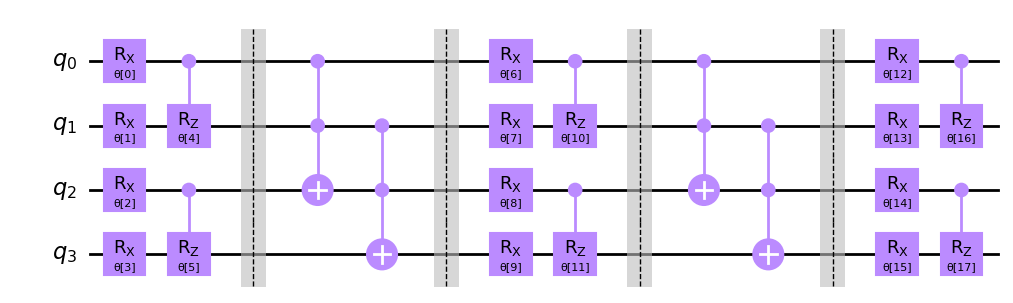

In [46]:
# Ansatz

def build_NLocal(num_qubits, reps=2):
    # Creamos un vector de parámetros único por repetición y por qubit
    theta = Parameter("θ")

    entanglement_list = []
    for j in range(num_qubits-2):
        entanglement_list.append([j, j+1, j+2])

    # Usamos puertas RX y CX (pueden cambiarse por otras si prefieres)
    ansatz = NLocal(
        num_qubits=num_qubits,
        rotation_blocks=[RXGate(theta), CRZGate(theta)],
        entanglement_blocks=CCXGate(),
        entanglement=entanglement_list, #'linear', 'full', 'circular', etc.
        reps=reps,
        insert_barriers=True,
        parameter_prefix="θ"
    )
    
    return ansatz, ansatz.num_parameters

ansatz, n_params = build_NLocal(4)
ansatz.decompose().draw("mpl")

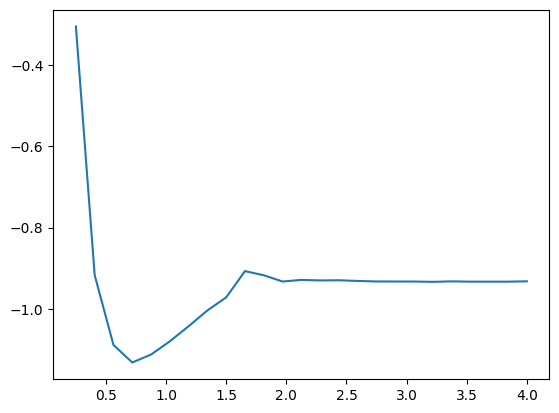

In [ ]:
# Cargamos los hamiltonianos y las energías de repulsión y aplicamos el VQE

distances = np.linspace(0.25, 4, 25)
total_energies = []

for dist in distances:
    # Hamiltonianos
    with open(f"data/hamiltonian{dist:.3f}.pkl", "rb") as f:
        hamiltonian = pickle.load(f)
    # Energías de repulsión
    with open(f"data/nuclear_repulsion{dist:.3f}.pkl", "rb") as f:
        nuclear_repulsion = pickle.load(f)

    total_energies.append(cf.VQE_minimization_BP(build_NLocal, 4, 4, hamiltonian, [], print_info=False, plot_info=False)["minimum_values"][0] + nuclear_repulsion)

plt.plot(distances, total_energies)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80499838+0.j,  0.17472226+0.j, -0.23347838+0.j,  0.12184887+0.j,
  0.17472226+0.j,  0.16970294+0.j, -0.23347838+0.j,  0.16685625+0.j,
  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,  0.04500738+0.j,
  0.16685625+0.j,  0.17539742+0.j,  0.12184887+0.j])

Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.03716057211789833
Varianza de la derivada: 0.015908318032484103

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.02851996999134648
Varianza de la derivada: 0.007114603561990323

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.02016024333223356
Varianza de la derivada: 0.003367757330146568

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.01635812312700265
Varianza de la derivada: 0.0018441178938813608

Calculando varianzas con 8 qubits.

Varianza del valo

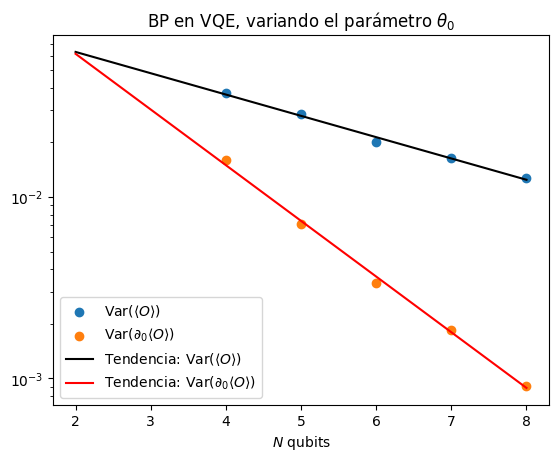


Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.03727457032327928
Varianza de la derivada: 0.022453885301148127

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.027843800390883335
Varianza de la derivada: 0.01382068712001636

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.018703012833234816
Varianza de la derivada: 0.004759762916258766

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.01612489645875514
Varianza de la derivada: 0.003176677487260103

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.014317531678780441
Varianza de la derivada: 0.0019159117881665747

Pendiente para valor esperado: -0.2459899003944646.
R^2 para valor esperado: 0.9499391904527429.

Pendiente para derivada: -0.6392870750974436.
R^2 para derivada: 0.9742639950859473.


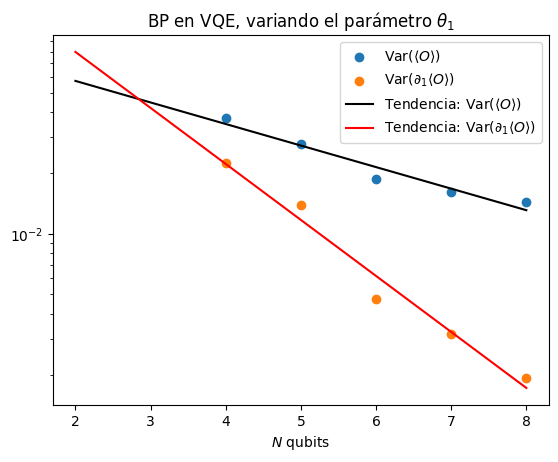


Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.03814061184178873
Varianza de la derivada: 0.014188217555567722

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.029436828543720858
Varianza de la derivada: 0.012351486331120275

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.01925422949710134
Varianza de la derivada: 0.0069103091239461475

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.016373682787293776
Varianza de la derivada: 0.003446304812210962

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.011386540872337281
Varianza de la derivada: 0.0016509456882950087

Pendiente para valor esperado: -0.30042664428688376.
R^2 para valor esperado: 0.9872111053799193.

Pendiente para derivada: -0.5578601023250505.
R^2 para derivada: 0.9570792101419137.


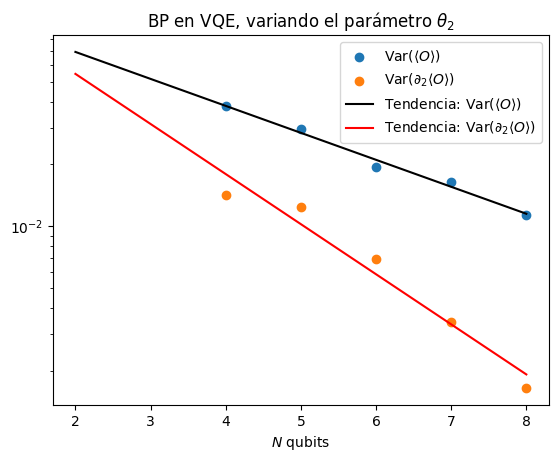

In [49]:
# Analizamos BP alrededor del punto de equilibrio estable d = 0.719

with open("data/hamiltonian0.719.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print(hamiltonian)

data = []

for j in range(3):
    data.append(cf.variance_vs_nQubits(build_NLocal, 4, 8, hamiltonian, j, 1000, True, True, True))

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.83117017+0.j,  0.0837334 +0.j, -0.01861043+0.j,  0.07640825+0.j,
  0.0837334 +0.j,  0.13407954+0.j, -0.01861043+0.j,  0.13625801+0.j,
  0.05984976+0.j,  0.05984976+0.j,  0.05984976+0.j,  0.05984976+0.j,
  0.13625801+0.j,  0.14151217+0.j,  0.07640825+0.j])

Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.009578331920291174
Varianza de la derivada: 0.00551407746275513

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.009257314838623538
Varianza de la derivada: 0.0018225156383838356

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.005432980615329366
Varianza de la derivada: 0.001082238215022866

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.004630041199684579
Varianza de la derivada: 0.0005806791973261796

Calculando varianzas con 8 qubits.

Varianza del 

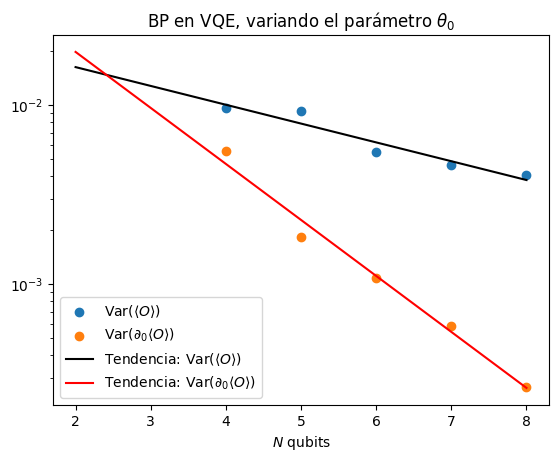


Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.009718745447430661
Varianza de la derivada: 0.004405021772152239

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.008539465179285617
Varianza de la derivada: 0.004199716944178398

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.00585074033187756
Varianza de la derivada: 0.0015543099068809044

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.004566220128159678
Varianza de la derivada: 0.0009442408707959376

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.004198790292530644
Varianza de la derivada: 0.00047298462130444157

Pendiente para valor esperado: -0.23045327887004322.
R^2 para valor esperado: 0.9598153297700337.

Pendiente para derivada: -0.5955266326603786.
R^2 para derivada: 0.9551976243680695.


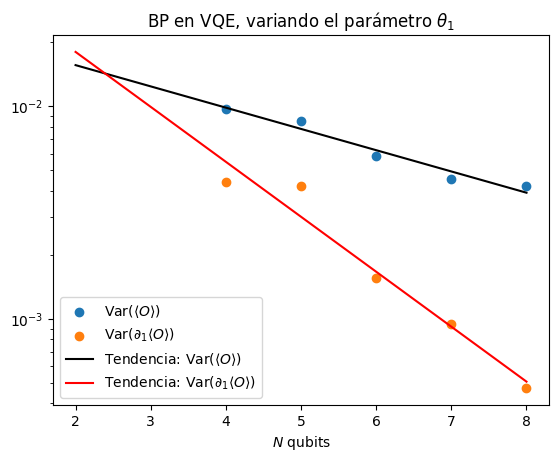


Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.009641737461686712
Varianza de la derivada: 0.005790195331438055

Calculando varianzas con 5 qubits.

Varianza del valor esperado: 0.008696312211096326
Varianza de la derivada: 0.003488988797657129

Calculando varianzas con 6 qubits.

Varianza del valor esperado: 0.005697185547086331
Varianza de la derivada: 0.002244305648968058

Calculando varianzas con 7 qubits.

Varianza del valor esperado: 0.004996945624331195
Varianza de la derivada: 0.0008464008610500149

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.004008248231193073
Varianza de la derivada: 0.0005337864100982222

Pendiente para valor esperado: -0.23095662637778905.
R^2 para valor esperado: 0.964526528175297.

Pendiente para derivada: -0.6184225208290548.
R^2 para derivada: 0.9812898087645957.


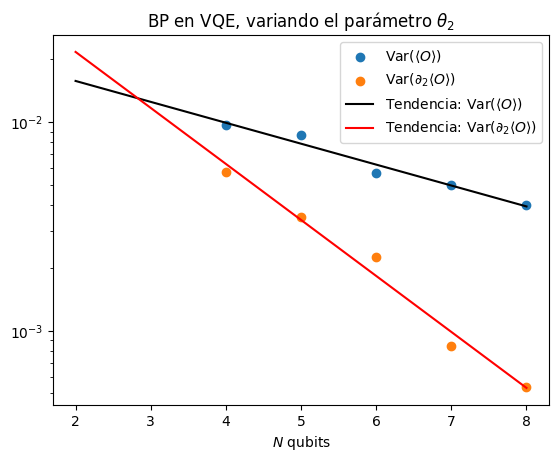

In [52]:
# Analizamos BP alrededor del punto de equilibrio estable d = 1.656

with open("data/hamiltonian1.656.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print(hamiltonian)

data = []

for j in range(3):
    data.append(cf.variance_vs_nQubits(build_NLocal, 4, 8, hamiltonian, j, 1000, True, True, True))